## Purpose of the notenbook 
1. Evaluate the performance of the selected tuned network on individual test records and the whole set.
2. Organize the summary statistics into a table
3. Finalize the output file graphs and discuss implications

In [1]:
import pandas as pd
import os
import sys
sys.path.insert(0, os.path.abspath('../../src/'))
import standard_mlp_cnn_fitting_funcs as sff
import eval_funcs as ef
import record_plot as rp
import importlib
from keras.models import load_model

Using TensorFlow backend.


In [2]:
# load and prepare test data for evaluation
test_df = pd.read_csv('../../Data_processed/test_040820.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,0,1,2,3,4,5,6,7,...,354,355,356,357,358,359,Patient_number,Label,Label_class,Output_label
0,0,10814,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.025,-0.010,-0.020,0.005,0.000,0.035,108,N,N,0.0
1,1,10815,0.025,-0.010,-0.020,0.005,0.000,0.035,-0.010,-0.015,...,0.005,0.000,-0.005,0.005,-0.005,0.025,108,N,N,0.0
2,2,10816,0.020,-0.010,-0.005,-0.020,0.000,0.010,0.020,0.005,...,0.030,-0.015,-0.010,-0.010,0.005,0.025,108,N,N,0.0
3,3,10817,0.000,0.005,-0.020,-0.010,-0.005,0.010,0.015,0.005,...,-0.015,0.000,-0.010,0.000,0.015,0.010,108,N,N,0.0
4,4,10818,-0.025,-0.005,0.020,0.005,0.010,-0.015,0.010,-0.005,...,-0.015,0.015,0.035,0.005,-0.050,-0.040,108,N,N,0.0


In [3]:
test_df.drop('Unnamed: 0.1', axis=1, inplace=True)
# label class count for each record
class_summary = test_df.groupby(['Patient_number', 'Label_class'])['Label_class'].count()
class_summary = class_summary.unstack(level=1)
class_summary.columns = ['F', 'N', 'S', 'V']
class_summary

,F,N,S,V
Patient_number,,,,
108,2.0,1740.0,4.0,17.0
114,4.0,1820.0,12.0,43.0
118,NaN,2166.0,96.0,16.0
203,1.0,2529.0,2.0,444.0
210,10.0,2423.0,22.0,195.0
213,362.0,2641.0,28.0,220.0
214,1.0,2003.0,NaN,256.0
220,NaN,1954.0,94.0,NaN
228,NaN,1688.0,3.0,362.0


In [4]:
total_count_summary = test_df.groupby('Label_class')['Label_class'].count()
total_count_summary

Label_class
F      380
N    21664
S      311
V     1556
Name: Label_class, dtype: int64

In [5]:
# load the tuned model
model = load_model('../../models/train_val_test_split/2_3_layer_split_on_records_F1/3_32_0.25_5_best_model.h5', custom_objects={'f1_metric': sff.f1_metric})
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_54 (Dropout)         (None, 360, 1)            0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 356, 32)           192       
_________________________________________________________________
dropout_55 (Dropout)         (None, 356, 32)           0         
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 71, 32)            0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 67, 32)            5152      
_________________________________________________________________
dropout_56 (Dropout)         (None, 67, 32)            0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 13, 32)          

In [6]:
# evaluate each record and collect the summary statistics into an array
pd.set_option('mode.chained_assignment', None)
patient_list = test_df.Patient_number.unique().tolist()
result_array = []
cm_list = []
for patient in patient_list:
    test_data = test_df[test_df.Patient_number == patient]
    x_test, y_test, target_unique = ef.prepTestSet(test_data)
    array, cm = ef.modelEvaluator(x_test, y_test, model, target_unique)
    result_array.append(array)
    cm_list.append(cm)

2753/2753 [==============================] - 0s 77us/step


In [7]:
df = pd.DataFrame(result_array, columns = ['SeV', 'PrV', 'fprV', 'AccV', 'SeS', 'PrS', 'fprS', 'AccS', 'SeF', \
                                           'Sp', 'Acc'], index = patient_list)
df

,SeV,PrV,fprV,AccV,SeS,PrS,fprS,AccS,SeF,Sp,Acc
108,0.059,0.333,0.001,0.990,0.000,0.000,0.002,0.996,0.000,0.997,0.985
114,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.994,0.000,1.000,0.991
118,0.062,0.003,0.176,0.819,0.000,0.000,0.000,0.958,NaN,0.847,0.806
203,0.696,0.490,0.127,0.847,0.000,0.000,0.006,0.994,0.000,0.869,0.842
210,0.605,1.000,0.000,0.971,0.045,0.071,0.005,0.987,0.000,1.000,0.959
213,0.986,0.991,0.001,0.998,0.429,0.800,0.001,0.994,0.006,0.999,0.882
214,0.738,0.984,0.001,0.969,NaN,NaN,0.000,NaN,0.000,0.999,0.969
220,NaN,NaN,0.000,NaN,0.426,1.000,0.000,0.974,NaN,1.000,0.974
228,0.445,1.000,0.000,0.902,0.000,0.000,0.000,0.998,NaN,0.999,0.900
234,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.982,NaN,1.000,0.982


In [8]:
df = pd.concat([df, class_summary[['V', 'S', 'F']]], axis=1, ignore_index=False)
df

,SeV,PrV,fprV,AccV,SeS,PrS,fprS,AccS,SeF,Sp,Acc,V,S,F
108,0.059,0.333,0.001,0.990,0.000,0.000,0.002,0.996,0.000,0.997,0.985,17.0,4.0,2.0
114,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.994,0.000,1.000,0.991,43.0,12.0,4.0
118,0.062,0.003,0.176,0.819,0.000,0.000,0.000,0.958,NaN,0.847,0.806,16.0,96.0,NaN
203,0.696,0.490,0.127,0.847,0.000,0.000,0.006,0.994,0.000,0.869,0.842,444.0,2.0,1.0
210,0.605,1.000,0.000,0.971,0.045,0.071,0.005,0.987,0.000,1.000,0.959,195.0,22.0,10.0
213,0.986,0.991,0.001,0.998,0.429,0.800,0.001,0.994,0.006,0.999,0.882,220.0,28.0,362.0
214,0.738,0.984,0.001,0.969,NaN,NaN,0.000,NaN,0.000,0.999,0.969,256.0,NaN,1.0
220,NaN,NaN,0.000,NaN,0.426,1.000,0.000,0.974,NaN,1.000,0.974,NaN,94.0,NaN
228,0.445,1.000,0.000,0.902,0.000,0.000,0.000,0.998,NaN,0.999,0.900,362.0,3.0,NaN
234,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.982,NaN,1.000,0.982,3.0,50.0,NaN


In [9]:
# evaluate the whole test set
x_test, y_test, target_unique = ef.prepTestSet(test_df)
print(x_test.shape, y_test.shape)

(23911, 360, 1) (23911, 4)


In [10]:
array, cm = ef.modelEvaluator(x_test, y_test, model, target_unique)
cm

23911/23911 [==============================] - 2s 75us/step


array([[20987,    19,   658,     0],
       [  190,    53,    68,     0],
       [  496,    18,  1042,     0],
       [  272,     0,   106,     2]], dtype=int32)

In [11]:
df_overall = pd.DataFrame(array, index = ['SeV', 'PrV', 'fprV', 'AccV', 'SeS', 'PrS', 'fprS', 'AccS', 'SeF', 'Sp', 'Acc'], columns = ['Overall']).T
df_overall

,SeV,PrV,fprV,AccV,SeS,PrS,fprS,AccS,SeF,Sp,Acc
Overall,0.67,0.589,0.033,0.948,0.17,0.589,0.002,0.988,0.005,0.969,0.924


In [12]:
df_overall['V'] = total_count_summary['V']
df_overall['S'] = total_count_summary['S']
df_overall['F'] = total_count_summary['F']
df_overall

,SeV,PrV,fprV,AccV,SeS,PrS,fprS,AccS,SeF,Sp,Acc,V,S,F
Overall,0.67,0.589,0.033,0.948,0.17,0.589,0.002,0.988,0.005,0.969,0.924,1556,311,380


In [13]:
# concatenate summary statistics for individual records and overall set
df = pd.concat([df, df_overall], axis=0)
df 

,SeV,PrV,fprV,AccV,SeS,PrS,fprS,AccS,SeF,Sp,Acc,V,S,F
108,0.059,0.333,0.001,0.990,0.000,0.000,0.002,0.996,0.000,0.997,0.985,17.0,4.0,2.0
114,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.994,0.000,1.000,0.991,43.0,12.0,4.0
118,0.062,0.003,0.176,0.819,0.000,0.000,0.000,0.958,NaN,0.847,0.806,16.0,96.0,NaN
203,0.696,0.490,0.127,0.847,0.000,0.000,0.006,0.994,0.000,0.869,0.842,444.0,2.0,1.0
210,0.605,1.000,0.000,0.971,0.045,0.071,0.005,0.987,0.000,1.000,0.959,195.0,22.0,10.0
213,0.986,0.991,0.001,0.998,0.429,0.800,0.001,0.994,0.006,0.999,0.882,220.0,28.0,362.0
214,0.738,0.984,0.001,0.969,NaN,NaN,0.000,NaN,0.000,0.999,0.969,256.0,NaN,1.0
220,NaN,NaN,0.000,NaN,0.426,1.000,0.000,0.974,NaN,1.000,0.974,NaN,94.0,NaN
228,0.445,1.000,0.000,0.902,0.000,0.000,0.000,0.998,NaN,0.999,0.900,362.0,3.0,NaN
234,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.982,NaN,1.000,0.982,3.0,50.0,NaN


In [14]:
# rearrange the columns for easier viewing
df_rearranged = df[['V', 'SeV', 'PrV', 'fprV', 'AccV', 'S', 'SeS', 'PrS', 'fprS', 'AccS', 'F', 'SeF', 'Sp', 'Acc']]
df_rearranged.columns = ['#V', 'SeV', 'PrV', 'fprV', 'AccV', '#S', 'SeS', 'PrS', 'fprS', 'AccS', '#F', 'SeF', 'Sp', 'Acc']
df_rearranged

,#V,SeV,PrV,fprV,AccV,#S,SeS,PrS,fprS,AccS,#F,SeF,Sp,Acc
108,17.0,0.059,0.333,0.001,0.990,4.0,0.000,0.000,0.002,0.996,2.0,0.000,0.997,0.985
114,43.0,1.000,1.000,0.000,1.000,12.0,0.000,0.000,0.000,0.994,4.0,0.000,1.000,0.991
118,16.0,0.062,0.003,0.176,0.819,96.0,0.000,0.000,0.000,0.958,NaN,NaN,0.847,0.806
203,444.0,0.696,0.490,0.127,0.847,2.0,0.000,0.000,0.006,0.994,1.0,0.000,0.869,0.842
210,195.0,0.605,1.000,0.000,0.971,22.0,0.045,0.071,0.005,0.987,10.0,0.000,1.000,0.959
213,220.0,0.986,0.991,0.001,0.998,28.0,0.429,0.800,0.001,0.994,362.0,0.006,0.999,0.882
214,256.0,0.738,0.984,0.001,0.969,NaN,NaN,NaN,0.000,NaN,1.0,0.000,0.999,0.969
220,NaN,NaN,NaN,0.000,NaN,94.0,0.426,1.000,0.000,0.974,NaN,NaN,1.000,0.974
228,362.0,0.445,1.000,0.000,0.902,3.0,0.000,0.000,0.000,0.998,NaN,NaN,0.999,0.900
234,3.0,1.000,1.000,0.000,1.000,50.0,0.000,0.000,0.000,0.982,NaN,NaN,1.000,0.982


## Result interpretation
1. The model works better for some records than others, e.g. 114 vs 108
2. Class V has better sensitivity, precision and (in most cases) accuracy than class S
3. Class F is poorly identified
4. 97% overall specificity is reasonable

## Following are some ideas for individual record review process improvement
I will consider several case scenarios that might benefit from presenting results differently based on prediction probability
1. there is a large number, e.g. >50% abnormal beats. To help the reviewer go through flagged beats faster we can split the abnormal beat predicions into high confidence and low confidence groups. Perhaps after reviewing the high confidence group (which are more likely to be correct), there are enough identified abnormal beats for diagnosis and there is no further need to review the low confidence beats. This will cut the review time by 20% (see below).
2. The opposite problem, there are much fewer abnormal beats, e.g. 1-2%. In this case the reviewer can first go through high confidence abnormal beats, then low confidence, then go through low confidence normal beat predictions (as those are more likely to be false negatives). Spliting the beat review process into steps makes it more systematic and manageable, since fewer annotations are displayed on the graph at any one time.

In [16]:
# get probabilities for wach class predicion and concatenate with ground truth label class info
y_pred = model.predict_proba(x_test, batch_size=32, verbose=1)

# turn y_pred into a dataframe and concatenate to test_df
pred_df = pd.DataFrame(y_pred)
pred_df.columns = ['N_pred', 'S_pred', 'V_pred', 'F_pred']

# at this point we don't need the features any more, keep only the label ground truth and predicitons columns
test_df_pred = pd.concat([test_df[['Patient_number','Label','Label_class','Output_label']], pred_df], axis=1)
print(test_df_pred.shape)
test_df_pred.head()

23911/23911 [==============================] - 2s 78us/step
(23911, 8)


,Patient_number,Label,Label_class,Output_label,N_pred,S_pred,V_pred,F_pred
0,108,N,N,0.0,0.962943,0.027000,0.008314,0.001744
1,108,N,N,0.0,0.892997,0.088956,0.015831,0.002217
2,108,N,N,0.0,0.894934,0.094544,0.009283,0.001239
3,108,N,N,0.0,0.941958,0.040266,0.015103,0.002672
4,108,N,N,0.0,0.957682,0.034276,0.006694,0.001349


In [17]:
# make a prediction based on the index of maximum value in the 4 prediction columns
# also translate the prediction into label_class format
import numpy as np
test_df_pred['Prediction'] = np.argmax(test_df_pred[['N_pred', 'S_pred', 'V_pred', 'F_pred']].values, axis=1)
test_df_pred.loc[test_df_pred['Prediction']==0, 'Label_pred']='N'
test_df_pred.loc[test_df_pred['Prediction']==1, 'Label_pred']='S'
test_df_pred.loc[test_df_pred['Prediction']==2, 'Label_pred']='V'
test_df_pred.loc[test_df_pred['Prediction']==3, 'Label_pred']='F'
#test_df_pred.loc[np.max(test_df_pred[['N_pred', 'S_pred', 'V_pred', 'F_pred']].values, axis=1)>=0.95,\
#                 'Confidence']=1
#test_df_pred.Confidence.fillna(0, inplace=True)
# pull out the probability of class prediction into a separate column
test_df_pred['Probability'] = np.max(test_df_pred[['N_pred', 'S_pred', 'V_pred', 'F_pred']].values, axis=1)
test_df_pred['Probability'] = round(test_df_pred['Probability'],2)
test_df_pred.head()

,Patient_number,Label,Label_class,Output_label,N_pred,S_pred,V_pred,F_pred,Prediction,Label_pred,Probability
0,108,N,N,0.0,0.962943,0.027000,0.008314,0.001744,0,N,0.96
1,108,N,N,0.0,0.892997,0.088956,0.015831,0.002217,0,N,0.89
2,108,N,N,0.0,0.894934,0.094544,0.009283,0.001239,0,N,0.89
3,108,N,N,0.0,0.941958,0.040266,0.015103,0.002672,0,N,0.94
4,108,N,N,0.0,0.957682,0.034276,0.006694,0.001349,0,N,0.96


In [19]:
test_df_pred.to_csv('../../Data_processed/test_predictions_final.csv', index=False)

In order to help decide which probabiliy cutoff to choose need to answer some questions:
1. at a given probability cut off what is the precision (of abnormal class predicton) in the lower and hihger confidence groups, i.e. is the split producing a worthwhile improvement in precision?
2. at a given probability cut off what is the fraction of abnormal beat predicitons in the lower and higher confidence groups, i.e. is the fraction left in the high confidence group after the split the majority?

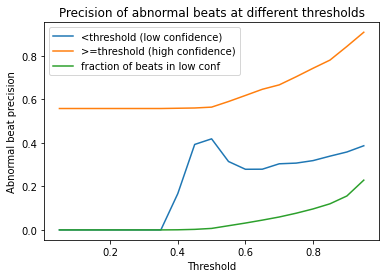

In [19]:
import matplotlib.pyplot as plt
def precDifCalc(df, p):
    low_conf = df[df['Probability']<p]
    high_conf = df[df['Probability']>=p]
    fract_samp_low = len(low_conf['Label_class'].isin(['S', 'V', 'F']))/len(df['Label_class'].isin(['S', 'V', 'F']))
    
    def precCalc(df):
        tp=((df['Label_class'].isin(['S', 'V', 'F'])) & (df['Label_class']==df['Label_pred'])).sum().sum()
        pred = df['Label_pred'].isin(['S', 'V', 'F']).sum()
        prec = tp/(pred+np.finfo(float).eps)
        return prec
    
    low_prec = precCalc(low_conf)
    high_prec = precCalc(high_conf)
    return low_prec, high_prec, fract_samp_low

test_vals = np.arange(0.05, 1, 0.05)
low_precs = []
high_precs = []
fract_samp_lows = []
for val in test_vals:
    low_prec, high_prec, fract_samp_low = precDifCalc(test_df_pred, val)
    low_precs.append(low_prec)
    high_precs.append(high_prec)
    fract_samp_lows.append(fract_samp_low)
    
plt.plot(test_vals, low_precs, label='<threshold (low confidence)')
plt.plot(test_vals, high_precs, label='>=threshold (high confidence)')
plt.plot(test_vals, fract_samp_lows, label='fraction of beats in low conf')
plt.ylabel('Abnormal beat precision')
plt.xlabel('Threshold')
plt.title('Precision of abnormal beats at different thresholds')
plt.legend()

#### Interpretation: There are no beats with highers probability of prediction < ~0.35 (flat green and blue lines at 0). The average precision for the whole set is ~0.55 (orange line for 0.05<threshold<=0.35). The maximum precision is ~0.9 and is reached at threshold 0.095. At this same threshold, the fraction of abnormal beats in the low confidence set is 20%, hence the majority (80%) is in the high confidence group. Based on this analysis 0.095 is a good threshold for splitting abnormal beat predicitons into low and high confidence groups. 

#### How about low confidence normal beat predictions? We need the fraction of false negatives to be as high as possible, yet the overall number of normal beat predictions to be as low as possible, otherwize we will be adding a lot of time to trace review.

/Users/zhannahakhverdyan/anaconda3/envs/mit-bih-arrhythmia-database-1.0.0/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in long_scalars



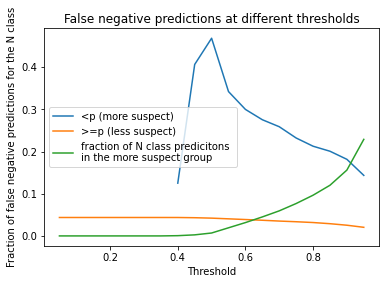

In [20]:
def precFNRDif(df, p):
    low_conf = df[df['Probability']<p]
    high_conf = df[df['Probability']>=p]
    fract_samp_low = len(low_conf['Label_pred'].isin(['N']))/len(df['Label_pred'].isin(['N']))
    
    def fprCalc(df):
        fn=((df['Label_class'].isin(['S', 'V', 'F'])) & (df['Label_pred']=='N')).sum().sum()
        total_n = (df['Label_pred']=='N').sum().sum()
        fnr = fn/total_n
        return fnr
    
    low_fpr = fprCalc(low_conf)
    high_fpr = fprCalc(high_conf)
    return low_fpr, high_fpr, fract_samp_low

test_vals = np.arange(0.05, 1, 0.05)
low_fprs = []
high_fprs = []
fract_samp_lows = []
for val in test_vals:
    low_fpr, high_fpr, fract_samp_low = precFNRDif(test_df_pred, val)
    low_fprs.append(low_fpr)
    high_fprs.append(high_fpr)
    fract_samp_lows.append(fract_samp_low)
    
plt.plot(test_vals, low_fprs, label='<p (more suspect)')
plt.plot(test_vals, high_fprs, label='>=p (less suspect)')
plt.plot(test_vals, fract_samp_lows, label='fraction of N class predicitons \nin the more suspect group')
plt.xlabel('Threshold')
plt.ylabel('Fraction of false negative predictions for the N class')
plt.title('False negative predictions at different thresholds')
plt.legend()

### Interpretation: based on this graph at threshold value of 0.55 is the highest fraction of false negative N class predicitons, while a small fraction (~0.01) of overall N class predicitons is in the more suspect group (the group that needs to be reviewed for potential bnormal beats.

In [21]:
importlib.reload(rp)

<module 'record_plot' from '/Users/zhannahakhverdyan/Springboard/Capstone2/src/record_plot.py'>

### Note, becuase of Github's size limitation requirements I cannot save the plots in the notebook. To display plotly graphs uncomment and run the cell below.

In [1]:
"""
import ipywidgets
for record in test_df.Patient_number.unique().tolist():
    rp.recordPlot(str(record), test_df_pred)
"""

'\nimport ipywidgets\nfor record in test_df.Patient_number.unique().tolist():\n    rp.recordPlot(str(record), test_df_pred)\n'

In [195]:
# calculate the prevalence of abnormal beats
label_summary = test_df_pred.Label_class.value_counts()
prevalence = label_summary[['S', 'V', 'F']].sum()/label_summary.sum()
print("Average prevalence of abnormal beats: ", round(prevalence,3))
print("Average percentage of beats that the model detects: ", 0.489)
print("Average percent time saving per record review: ", round(100*(1-prevalence*0.489/\
                                                         0.323)))

Average prevalence of abnormal beats:  0.094
Average percentage of beats that the model detects:  0.489
Average percent time saving per record review:  86.0
